# Hw 09 - Lie Detection(Fake Reviews) and Sentiment Analysis

In [132]:
# importing required libraries

import pandas as pd
import seaborn as sns
import numpy as np

import nltk # For doing some preprocessing on our string data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('movie_reviews')
from nltk.corpus import stopwords # We will do some cleanup of the text

import re

from nltk.tokenize import sent_tokenize, word_tokenize # Cleanup will start with tokenization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [133]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


In [134]:
from nltk.corpus import movie_reviews
import random

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
# reading the data from csv file
review_list = []
lie_list = []
sentiment_list = []
with open('/content/drive/Othercomputers/My Laptop/syr_ads_ist707/week09text_mining/hw09/deception_data_converted_final.csv') as file_handler:
    lines = file_handler.readlines()
    # skipping header row
    for line in lines[1:]:
      line = line.strip() # removing trailing whitespaces
      columns = line.split(',')
      lie_list.append(columns[0]) # collecting lie
      sentiment_list.append(columns[1]) # collecting sentiment
      review_list.append(','.join(columns[2:])) # collecting reviews

In [137]:
review_dict = {'lie':lie_list,'sentiment':sentiment_list,'review':review_list}
df = pd.DataFrame(review_dict)
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the data set')

There are 92 rows and 3 columns in the data set


In [138]:
df.head()

,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very..."
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,"'After I went shopping with some of my friend,..."
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lie        92 non-null     object
 1   sentiment  92 non-null     object
 2   review     92 non-null     object
dtypes: object(3)
memory usage: 2.3+ KB


# Data Cleaning

In [140]:
# replacing any empty string in review to null
df = df.apply(lambda x: x.str.strip()).replace('', np.nan)

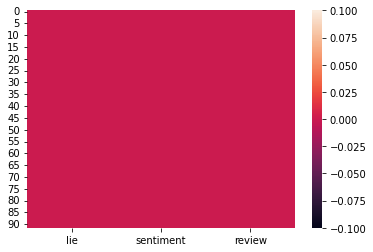

In [141]:
sns.heatmap(df.isnull()) # no null values found

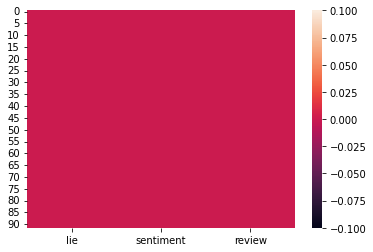

In [142]:
sns.heatmap(df.isna()) # no NA found

In [143]:
# checking for duplicate rows in the data
df[df.duplicated()==True]

,lie,sentiment,review
83,t,p,?


In [144]:
df[df['review']=='?']

,lie,sentiment,review
82,t,p,?
83,t,p,?


In [145]:
df.drop(df[df['review']=='?'].index, inplace=True) # removing rows having '?' in review

In [146]:
df.shape

(90, 3)

In [147]:
df.describe().T

,count,unique,top,freq
lie,90,2,f,46
sentiment,90,2,n,46
review,90,90,"'Mike\'s Pizza High Point, NY Service was very...",1


In [148]:
# converting categorical variables 'lie' and 'sentiment' to numeric values
df['lie'].replace({'f':1,'t':0}, inplace=True) # 1 indicates fake review, 0 indicates not a fake review
df['sentiment'].replace({'n':0,'p':1}, inplace=True) # 0 indicates negative polarity, 1 indicates positive polarity

In [149]:
df['lie'].value_counts()

1    46
0    44
Name: lie, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


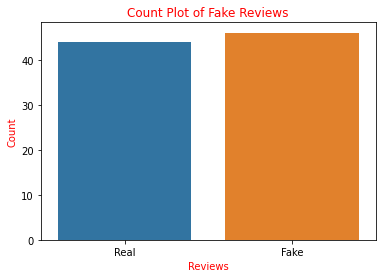

In [150]:
# distribution of Lie
sns.countplot(df['lie'])
plt.xlabel('Reviews', color = 'red')
plt.ylabel('Count', color = 'red')
plt.xticks([0,1],['Real','Fake'])
plt.title('Count Plot of Fake Reviews', color = 'r')
plt.show()


In [151]:
df['sentiment'].value_counts()

0    46
1    44
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


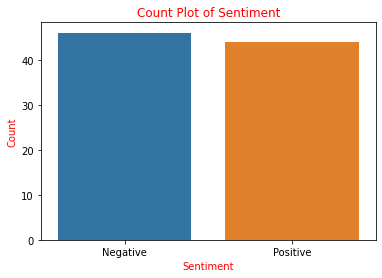

In [152]:
# distribution of sentiment polarity
sns.countplot(df['sentiment'])
plt.xlabel('Sentiment', color = 'red')
plt.ylabel('Count', color = 'red')
plt.xticks([0,1],['Negative','Positive'])
plt.title('Count Plot of Sentiment', color = 'r')
plt.show()


In [153]:
df.reset_index(drop=True,inplace=True)

# Data Pre Processing

- lowercase transformation of review column
- removing punctuation, and numbers from review column
- stop words removal while vectorizing the corpus

In [154]:
def ReturnCleanText(text):
         text = text.lower() # lowercase transformation
         text = re.sub(r"\W+|_", ' ', text) # removing numebers and punctuation
         return text

df['review'] = df['review'].apply(ReturnCleanText)


In [155]:
text =  ' '.join(df['review'])

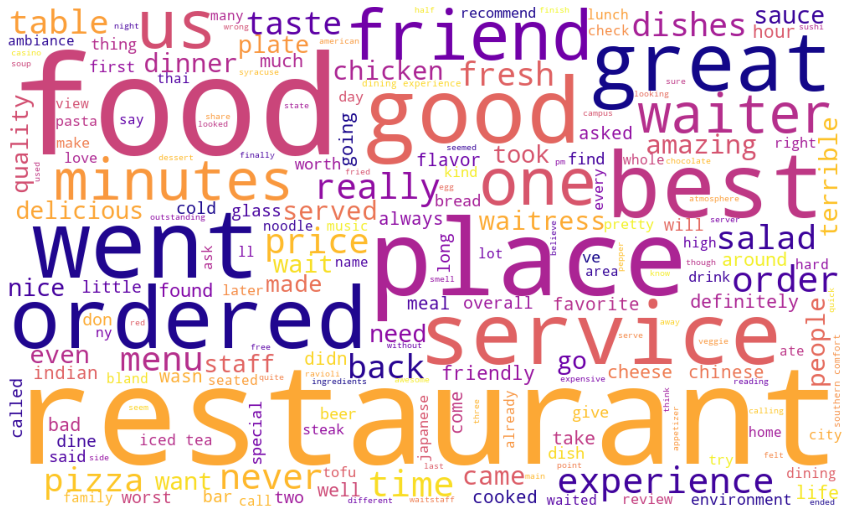

In [156]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(stopwords = STOPWORDS,
                background_color="white", 
                max_words=200, 
                width=1000, 
                height=600, 
                max_font_size=256,
                random_state=1, colormap='plasma').generate(text)

# plot the wordcloud object
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Naive Bayes for Sentiment Analysis

In [157]:
data = pd.read_csv('https://raw.githubusercontent.com/Hrd2D/Sentiment-analysis-on-Google-Play-store-apps-reviews/master/google_play_store_apps_reviews_training.csv')
data.shape

(891, 3)

In [158]:
data.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


Pre-process Data

In [159]:
def preprocess_data(data):
    # Remove package name as it's not relevant
    data = data.drop('package_name', axis=1)
    
    # Convert text to lowercase
    data['review'] = data['review'].str.strip().str.lower()
    return data
data = preprocess_data(data)

In [160]:
X = data['review']
Y = data['polarity']

In [161]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,stratify=Y ,test_size=0.25, random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((668,), (223,), (668,), (223,))

In [162]:
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english') # removing stop words during vectorization
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()
testset = vec.transform(df['review']).toarray()

In [163]:
multi_nb = MultinomialNB()
multi_nb.fit(x_train, y_train)

MultinomialNB()

In [164]:
multi_nb.score(x_test,y_test)

0.8565022421524664

# Support Vector Classifier (SVC) for Sentiment Analysis

In [165]:
from sklearn.svm import SVC
svc_clf = SVC(kernel='linear')
svc_clf.fit(x_train, y_train)

SVC(kernel='linear')

In [166]:
svc_clf.score(x_test, y_test)

0.7892376681614349

Accuracy of the MultiNominal Naive Bayes classifier (0.85) is better than Support Vector Classifier (0.79) for Sentiment Analysis of Reviews. Hence, choosing Naive Bayes Classifier for predicting the sentiments for the given dataset

In [167]:
# Look at confusion matrix 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [168]:
test_result = multi_nb.predict(testset) # predicted
gold_result = df['sentiment'].to_numpy() # already labelled

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        46
           1       0.82      0.82      0.82        44

    accuracy                           0.82        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.82      0.82      0.82        90



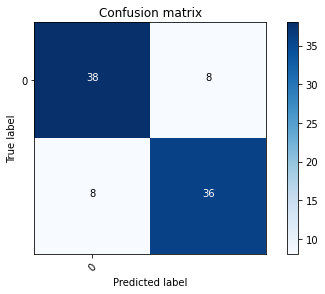

In [169]:
#### MODEL EVALUATION - ACCURACY, PRECISION, RECALL, and F1 SCORE

# compute the confusion matrix
confusion_knn = confusion_matrix(gold_result, test_result) 
# plot the confusion matrix
plot_confusion_matrix(confusion_knn, classes = range(1)) 

from sklearn.metrics import classification_report

print(classification_report(gold_result, test_result))

In [170]:
df['sentiment_pred'] = test_result

# Random Forest for Sentiment Analysis

In [171]:
from sklearn.ensemble import RandomForestClassifier

In [172]:
rf_best_model = RandomForestClassifier( criterion= 'gini', n_estimators=400,max_features= 'auto')
rf_best_model.fit(x_train, y_train)
rf_best_model.score(x_test, y_test)

0.8430493273542601

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


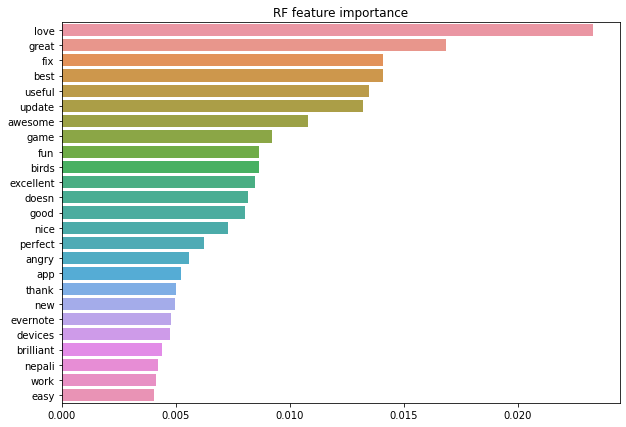

In [173]:
# get features importance
rf_feature_importance = pd.Series(rf_best_model.feature_importances_,index=vec.get_feature_names()).sort_values(ascending=False)[:25]

plt.figure(figsize=(10,7))
sns.barplot(x = rf_feature_importance, y = rf_feature_importance.index)

plt.title("RF feature importance")
plt.show()

- lemmatization

In [174]:
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatizing_review(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])

data['lemmatized_review'] = data['review'].apply(lemmatizing_review)

In [175]:
data.head()

,review,polarity,lemmatized_review
0,privacy at least put some option appear offlin...,0,privacy at least put some option appear offlin...
1,"messenger issues ever since the last update, i...",0,"messenger issue ever since the last update , i..."
2,profile any time my wife or anybody has more t...,0,profile any time -PRON- wife or anybody have m...
3,the new features suck for those of us who don'...,0,the new feature suck for those of -PRON- who d...
4,forced reload on uploading pic on replying com...,0,force reload on upload pic on reply comment la...


In [176]:
X = data['lemmatized_review']
Y = data['polarity']

In [177]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,stratify=Y ,test_size=0.25, random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((668,), (223,), (668,), (223,))

In [178]:
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english') # removing stop words during vectorization
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

# MultiNominal Naive Bayes Classifier

In [179]:
multi_nb = MultinomialNB()
multi_nb.fit(x_train, y_train)

MultinomialNB()

In [180]:
multi_nb.score(x_test,y_test)

0.8116591928251121

# Support Vector Classifier

In [181]:
svc_clf = SVC(kernel='linear')
svc_clf.fit(x_train, y_train)

SVC(kernel='linear')

In [182]:
svc_clf.score(x_test, y_test)

0.8116591928251121

# Lie Detection (Fake Reviews)

# Naive Bayes

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [184]:
# Split into training and testing data
x_df = df['review']
y = df['lie']

In [185]:
count_vectorizer = CountVectorizer(stop_words="english")
count_vectorizer.fit_transform(x_df)
freq_term_matrix = count_vectorizer.transform(x_df)


In [186]:
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [187]:
x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix,y,  test_size=0.25, random_state=0)

In [188]:
NB = MultinomialNB()
NB.fit(x_train, y_train)

MultinomialNB()

In [189]:
NB.score(x_test, y_test)

0.6521739130434783

# Support Vector Classifier (SVC)

In [190]:
svc_clf = SVC(kernel='linear')
svc_clf.fit(x_train, y_train)

SVC(kernel='linear')

In [191]:
svc_clf.score(x_test, y_test)

0.6086956521739131

In [192]:
lie_pred = NB.predict(x_test) # predicted

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.64      0.75      0.69        12

    accuracy                           0.65        23
   macro avg       0.65      0.65      0.65        23
weighted avg       0.65      0.65      0.65        23



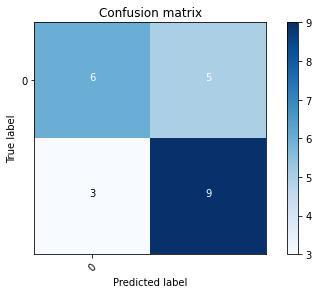

In [193]:
#### MODEL EVALUATION - ACCURACY, PRECISION, RECALL, and F1 SCORE

# compute the confusion matrix
confusion_knn = confusion_matrix(y_test, lie_pred)
# plot the confusion matrix
plot_confusion_matrix(confusion_knn, classes = range(1)) 

from sklearn.metrics import classification_report

print(classification_report(y_test, lie_pred))

Including sentiment feature for predicting fake review

MultiNominal Naive Bayes

In [194]:
# Split into training and testing data
x_review = df['review']
y = df['lie']

In [195]:
count_vectorizer = CountVectorizer(stop_words="english")
count_vectorizer.fit_transform(x_review).todense()
freq_term_matrix = count_vectorizer.transform(x_review)

In [196]:
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix).todense()

In [197]:
temp_df = df.copy()
temp_df.drop('review',axis=1, inplace=True)

# join the tfidf values to the existing dataframe
temp_df = pd.DataFrame(tf_idf_matrix, columns=count_vectorizer.get_feature_names_out())
print(temp_df)


     10  100   15   16   20   25  2nd   30        50  5pm  ...  write  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...    ...   
85  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
86  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.115443  0.0  ...    0.0   
87  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
88  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   
89  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  ...    0.0   

    written  wrong  wrote  xyz  yeah  yelp  yesterday  york  yuenan  
0       0.0    0.0    0.0  0.0   0.0   0.0        0.0

In [198]:
df

,lie,sentiment,review,sentiment_pred
0,1,0,mike s pizza high point ny service was very s...,0
1,1,0,i really like this buffet restaurant in marsh...,1
2,1,0,after i went shopping with some of my friend ...,0
3,1,0,olive oil garden was very disappointing i exp...,1
4,1,0,the seven heaven restaurant was never known f...,0
...,...,...,...,...
85,0,1,pastablities is a locally owned restaurant in...,1
86,0,1,i like the pizza at dominoes for their specia...,1
87,0,1,it was a really amazing japanese restaurant t...,1
88,0,1,how do i even pick a best experience at joe s...,0


In [199]:
res = pd.concat([df, temp_df], axis=1)
res.shape

(90, 1258)

In [200]:
res.head()

,lie,sentiment,review,sentiment_pred,10,100,15,16,20,25,...,write,written,wrong,wrote,xyz,yeah,yelp,yesterday,york,yuenan
0,1,0,mike s pizza high point ny service was very s...,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,i really like this buffet restaurant in marsh...,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,after i went shopping with some of my friend ...,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,olive oil garden was very disappointing i exp...,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,the seven heaven restaurant was never known f...,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
res.drop(res[['lie','review','sentiment']],axis=1)

,sentiment_pred,10,100,15,16,20,25,2nd,30,50,...,write,written,wrong,wrote,xyz,yeah,yelp,yesterday,york,yuenan
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
x_train, x_test, y_train, y_test = train_test_split(res.drop(res[['lie','review','sentiment']],axis=1),y,  test_size=0.25, random_state=0)

In [203]:
NB = MultinomialNB()
NB.fit(x_train, y_train)

MultinomialNB()

In [204]:
NB.score(x_test, y_test)

0.6956521739130435

In [205]:
lie_pred = NB.predict(x_test) # predicted

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.69      0.75      0.72        12

    accuracy                           0.70        23
   macro avg       0.70      0.69      0.69        23
weighted avg       0.70      0.70      0.69        23



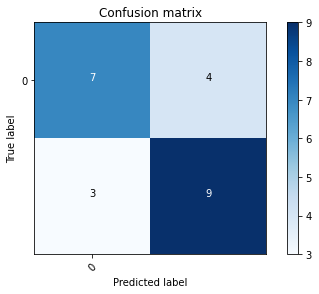

In [206]:
#### MODEL EVALUATION - ACCURACY, PRECISION, RECALL, and F1 SCORE

# compute the confusion matrix
confusion_knn = confusion_matrix(y_test, lie_pred)
# plot the confusion matrix
plot_confusion_matrix(confusion_knn, classes = range(1)) 

from sklearn.metrics import classification_report

print(classification_report(y_test, lie_pred))

# Random Forest for Lie Detection

In [216]:
rf_best_model = RandomForestClassifier( criterion= 'gini', n_estimators=300,max_features= 'auto')
rf_best_model.fit(x_train, y_train)
rf_best_model.score(x_test, y_test)

0.6521739130434783

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


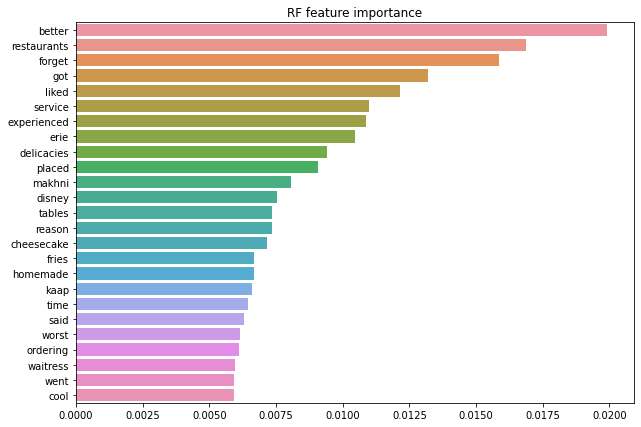

In [217]:
# get features importance
rf_feature_importance = pd.Series(rf_best_model.feature_importances_,index=count_vectorizer.get_feature_names()).sort_values(ascending=False)[:25]

plt.figure(figsize=(10,7))
sns.barplot(x = rf_feature_importance, y = rf_feature_importance.index)

plt.title("RF feature importance")
plt.show()

External Sources Used:

https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe


https://www.analyticsvidhya.com/blog/2021/07/performing-sentiment-analysis-with-naive-bayes-classifier/ 

https://bearworks.missouristate.edu/cgi/viewcontent.cgi?article=4454&context=theses